# A. Importing Libraries

In [2]:
from scipy.io import loadmat
import mne
import os
import glob
import h5py

import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.stats import pearsonr

# B. Importing Data

## 1. Data File Structure

- `data/`
  - `openendedloosely_cleaned/`
    - `Data_Design_Sub_x.mat`
  - `openendedloosely_raw/`
    - `Participant_x/`
      - `filename.vhdr` — header (metadata)
      - `filename.eeg` — EEG signal (binary samples)
      - `filename.vmrk` — event markers (timestamps)


## 2. Loading Raw Data

In [3]:
mne_data_path = os.path.abspath("../../data/openendedloosely_raw/")
vhdr_files = glob.glob(os.path.join(mne_data_path, "Participant_*", "*.vhdr"))

eeg_raw_data = {}

for vhdr in vhdr_files:
    participant_name = os.path.basename(os.path.dirname(vhdr))  
    print(f"Loading {participant_name}: {vhdr}")

    raw = mne.io.read_raw_brainvision(vhdr, preload=True)
    eeg_raw_data[participant_name] = raw

# MNE Raw objects
print("\nLoaded EEG datasets:", list(eeg_raw_data.keys()))
print("Total loaded:", len(eeg_raw_data))

Loading Participant_1: c:\Users\Aryo\PersonalMade\Programming\GAN\repo\data\openendedloosely_raw\Participant_1\Feb_07(1)_2014.vhdr
Extracting parameters from c:\Users\Aryo\PersonalMade\Programming\GAN\repo\data\openendedloosely_raw\Participant_1\Feb_07(1)_2014.vhdr...
Setting channel info structure...
Reading 0 ... 2612146  =      0.000 ...  5224.292 secs...
Loading Participant_10: c:\Users\Aryo\PersonalMade\Programming\GAN\repo\data\openendedloosely_raw\Participant_10\april_2(1).vhdr
Extracting parameters from c:\Users\Aryo\PersonalMade\Programming\GAN\repo\data\openendedloosely_raw\Participant_10\april_2(1).vhdr...
Setting channel info structure...
Reading 0 ... 1562175  =      0.000 ...  3124.350 secs...
Loading Participant_15: c:\Users\Aryo\PersonalMade\Programming\GAN\repo\data\openendedloosely_raw\Participant_15\april_16(1).vhdr
Extracting parameters from c:\Users\Aryo\PersonalMade\Programming\GAN\repo\data\openendedloosely_raw\Participant_15\april_16(1).vhdr...
Setting channel i

## 3. Loading Cleaned Data

### Inspect MATLAB Version

In [4]:
cleaned_path = os.path.abspath("../../data/openendedloosely_cleaned/")
mat_files = glob.glob(os.path.join(cleaned_path, "Data_Design_Sub_*.mat"))

def inspect_signature(path):
    with open(path, 'rb') as f:
        sig = f.read(128)
    return sig[:4], sig[:20]

for f in mat_files:
    filename = os.path.basename(f)   
    print(f"\nFile: {filename}")
    print(inspect_signature(f))



File: Data_Design_Sub_1.mat
(b'MATL', b'MATLAB 5.0 MAT-file,')

File: Data_Design_Sub_10.mat
(b'MATL', b'MATLAB 7.3 MAT-file,')

File: Data_Design_Sub_15.mat
(b'MATL', b'MATLAB 7.3 MAT-file,')

File: Data_Design_Sub_20.mat
(b'MATL', b'MATLAB 7.3 MAT-file,')

File: Data_Design_Sub_25.mat
(b'MATL', b'MATLAB 7.3 MAT-file,')

File: Data_Design_Sub_5.mat
(b'MATL', b'MATLAB 7.3 MAT-file,')


### Import data

In [5]:
cleaned_path = os.path.abspath("../../data/openendedloosely_cleaned/")
mat_files = glob.glob(os.path.join(cleaned_path, "Data_Design_Sub_*.mat"))

eeg_cleaned_data = {}

def is_v73(path):
    # There is two types of MATLAB version in data v5.0 and v7.3, each needs a special loader
    with open(path, "rb") as f:
        sig = f.read(20).decode(errors="ignore")
    return "MATLAB 7.3" in sig

for mat_file in mat_files:
    key = os.path.splitext(os.path.basename(mat_file))[0]
    print(f"Loading {key}: {os.path.basename(mat_file)}")

    if is_v73(mat_file):
        eeg_cleaned_data[key] = h5py.File(mat_file, "r")
    else:
        eeg_cleaned_data[key] = loadmat(mat_file)

# Python dictionary for v5.0
# HDF5 file object for v7.3
print("\nLoaded MAT datasets:", list(eeg_cleaned_data.keys()))
print("Total:", len(eeg_cleaned_data))

Loading Data_Design_Sub_1: Data_Design_Sub_1.mat
Loading Data_Design_Sub_10: Data_Design_Sub_10.mat
Loading Data_Design_Sub_15: Data_Design_Sub_15.mat
Loading Data_Design_Sub_20: Data_Design_Sub_20.mat
Loading Data_Design_Sub_25: Data_Design_Sub_25.mat
Loading Data_Design_Sub_5: Data_Design_Sub_5.mat

Loaded MAT datasets: ['Data_Design_Sub_1', 'Data_Design_Sub_10', 'Data_Design_Sub_15', 'Data_Design_Sub_20', 'Data_Design_Sub_25', 'Data_Design_Sub_5']
Total: 6


# C. Exploratory Data Analysis

## 1. Raw Data Description

### Raw EEG

In [6]:
def inspect_raw_eeg(raw):
    print("=== EEG RAW INFO ===")
    print(raw)

    print("\n=== CHANNELS ===")
    ch_names = raw.info['ch_names']
    print(ch_names[:10], "...") 

    data, times = raw.get_data(return_times=True)
    print("\n=== DATA SHAPE (channels x samples) ===")
    print(data.shape)

    print("\n=== SAMPLE PREVIEW (first channel, first 10 samples) ===")
    print(data[0, :10])

    # --- MIN / MAX PER CHANNEL ---
    print("\n=== MIN / MAX PER CHANNEL ===")
    ch_min = data.min(axis=1)
    ch_max = data.max(axis=1)

    for name, mn, mx in zip(ch_names, ch_min, ch_max):
        print(f"{name:>10s} | min = {mn:.6e}, max = {mx:.6e}")

    # --- GLOBAL MIN / MAX ---
    global_min = data.min()
    global_max = data.max()

    print("\n=== GLOBAL MIN / MAX ===")
    print(f"Global min = {global_min:.6e}")
    print(f"Global max = {global_max:.6e}")

inspect_raw_eeg(eeg_raw_data["Participant_1"])

=== EEG RAW INFO ===
<RawBrainVision | Feb_07(1)_2014.eeg, 63 x 2612147 (5224.3 s), ~1.23 GiB, data loaded>

=== CHANNELS ===
['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9'] ...

=== DATA SHAPE (channels x samples) ===
(63, 2612147)

=== SAMPLE PREVIEW (first channel, first 10 samples) ===
[-0.00796543 -0.00796101 -0.00796801 -0.00797028 -0.00797124 -0.00797133
 -0.00797287 -0.00797358 -0.00796958 -0.00796489]

=== MIN / MAX PER CHANNEL ===
       Fp1 | min = -1.269505e-02, max = -5.748177e-03
        Fz | min = -3.167713e-02, max = -1.737514e-02
        F3 | min = -3.215457e-02, max = -2.034650e-02
        F7 | min = -2.167624e-02, max = -6.694644e-03
       FT9 | min = -1.474191e-02, max = -2.078624e-03
       FC5 | min = -2.684135e-02, max = -1.909396e-02
       FC1 | min = 1.324133e-03, max = 3.358739e-03
        C3 | min = 4.648044e-03, max = 9.091086e-03
        T7 | min = -3.110176e-02, max = -2.283895e-02
       TP9 | min = -2.749313e-02, max = -1.279269e-02
 

### Cleaned EEG

In [8]:
def safe_preview(x, limit=10):
    """Return a short preview of any array/dataset."""
    try:
        arr = np.array(x)  
        flat = arr.ravel()
        return flat[:limit]
    except Exception:
        return "<unpreviewable>"

def inspect_mat_data(mat, preview_limit=10):
    global_min = None
    global_max = None

    def update_global(mn, mx):
        nonlocal global_min, global_max
        if isinstance(mn, (int, float, np.number)):
            global_min = mn if global_min is None else min(global_min, mn)
        if isinstance(mx, (int, float, np.number)):
            global_max = mx if global_max is None else max(global_max, mx)

    # SciPy case (v5)
    if isinstance(mat, dict):
        keys = [k for k in mat.keys() if not k.startswith("__")]
        print("Keys:", keys)

        for k in keys:
            v = mat[k]
            print(f"\n-- {k} --")

            if isinstance(v, np.ndarray):
                print("shape:", v.shape)
                print("preview:", safe_preview(v, preview_limit))
                if np.issubdtype(v.dtype, np.number):
                    mn, mx = v.min(), v.max()
                    print("min:", mn)
                    print("max:", mx)
                    update_global(mn, mx)
                else:
                    print("min/max: <non-numeric>")
            else:
                print("type:", type(v))
        
        # ---- GLOBAL AFTER LOOP ----
        print("\n=== GLOBAL MIN / MAX (ALL NUMERIC ARRAYS) ===")
        print("Global min:", global_min)
        print("Global max:", global_max)

    # HDF5 case (v7.3)
    elif isinstance(mat, h5py.File):
        keys = list(mat.keys())
        print("Keys:", keys)

        for k in keys:
            v = mat[k]
            print(f"\n-- {k} --")

            if isinstance(v, h5py.Dataset):
                print("shape:", v.shape)
                print("preview:", safe_preview(v, preview_limit))

                if np.issubdtype(v.dtype, np.number):
                    try:
                        mn = v[...].min()
                        mx = v[...].max()
                        print("min:", mn)
                        print("max:", mx)
                        update_global(mn, mx)
                    except Exception:
                        print("min/max: <uncomputable>")
                else:
                    print("min/max: <non-numeric>")

            elif isinstance(v, h5py.Group):
                print("Group with subkeys:", list(v.keys()))
    
        # ---- GLOBAL AFTER LOOP ----
        print("\n=== GLOBAL MIN / MAX (ALL NUMERIC DATASETS) ===")
        print("Global min:", global_min)
        print("Global max:", global_max)

print("=" * 80)
print("PREVIEW OF Data_Design_Sub_1")
print("=" * 80)
inspect_mat_data(eeg_cleaned_data["Data_Design_Sub_1"])

print()
print("=" * 80)
print("PREVIEW OF Data_Design_Sub_10")
print("=" * 80)
inspect_mat_data(eeg_cleaned_data["Data_Design_Sub_10"])

PREVIEW OF Data_Design_Sub_1
Keys: ['Design_1_1_IE', 'Design_1_1_IG', 'Design_1_1_PU', 'Design_1_1_RIE', 'Design_1_1_RIG', 'Design_1_2_IE', 'Design_1_2_IG', 'Design_1_2_PU', 'Design_1_2_RIE', 'Design_1_2_RIG', 'Design_1_3_IE', 'Design_1_3_IG', 'Design_1_3_PU', 'Design_1_3_RIE', 'Design_1_3_RIG', 'Design_1_4_IE', 'Design_1_4_IG', 'Design_1_4_PU', 'Design_1_4_RIE', 'Design_1_4_RIG', 'Design_1_5_IE', 'Design_1_5_IG', 'Design_1_5_PU', 'Design_1_5_RIE', 'Design_1_5_RIG', 'Design_1_6_IE', 'Design_1_6_IG', 'Design_1_6_PU', 'Design_1_6_RIE', 'Design_1_6_RIG', 'Design_1_RST1', 'Design_1_RST2']

-- Design_1_1_IE --
shape: (63, 18000)
preview: [9.02585853e-06 1.60095187e-05 1.89526859e-05 1.58640779e-05
 1.19633963e-05 1.06680568e-05 1.42827485e-05 2.01476532e-05
 2.50142040e-05 2.66213462e-05]
min: -5.080184932685147e-05
max: 5.041361012874433e-05

-- Design_1_1_IG --
shape: (63, 41500)
preview: [-5.91825580e-07 -2.38090595e-06 -3.32150893e-06 -3.28518556e-06
 -3.50044570e-06 -4.19427790e-06 -5.

## 2. Raw and Cleaned EEG Merge

In [33]:
unified_analysis = {}

for p_key in eeg_raw_data.keys():
    # Extract number: "Participant_10" → 10
    p_num = int(p_key.split("_")[1])

    mat_key = f"Data_Design_Sub_{p_num}"

    if mat_key not in eeg_cleaned_data:
        print(f"WARNING: Missing MAT data for {p_key}")
        continue

    unified_analysis[p_key] = {
        "raw_eeg": eeg_raw_data[p_key],
        "clean_eg": eeg_cleaned_data[mat_key]
    }

print("Unified participants:", list(unified_analysis.keys()))

Unified participants: ['Participant_1', 'Participant_10', 'Participant_15', 'Participant_20', 'Participant_25', 'Participant_5']


In [34]:
def safe_arr_shape(x):
    try:
        return np.array(x).shape
    except:
        return None

def preview_unified_analysis(unified, limit=5):
    print("\n=== UNIFIED DATASET PREVIEW ===")
    participants = list(unified.keys())
    print("Participants:", participants)

    for p in participants[:limit]:
        entry = unified[p]
        raw = entry["raw_eeg"]
        clean = entry["clean_eg"]

        print(f"\n--- {p} ---")

        # RAW EEG SUMMARY
        print("RAW EEG:")
        print(f"  Channels: {raw.info['nchan']}")
        print(f"  Sampling rate: {raw.info['sfreq']} Hz")

        data = raw.get_data()
        print(f"  Shape: {data.shape} (channels × samples)")

        # CLEAN MAT SUMMARY
        print("CLEANED DATA:")
        if isinstance(clean, dict):
            keys = [k for k in clean.keys() if not k.startswith("__")]
        else:  # h5py.File
            keys = list(clean.keys())

        print(f"  Keys: {keys}")

        # Show shapes of first few fields
        for k in keys[:5]: 
            v = clean[k]
            if isinstance(clean, dict):
                shape = safe_arr_shape(v)
            else:
                shape = v.shape if hasattr(v, "shape") else None

            print(f"    {k}: shape={shape}")

In [35]:
preview_unified_analysis(unified_analysis)


=== UNIFIED DATASET PREVIEW ===
Participants: ['Participant_1', 'Participant_10', 'Participant_15', 'Participant_20', 'Participant_25', 'Participant_5']

--- Participant_1 ---
RAW EEG:
  Channels: 63
  Sampling rate: 500.0 Hz
  Shape: (63, 2612147) (channels × samples)
CLEANED DATA:
  Keys: ['Design_1_1_IE', 'Design_1_1_IG', 'Design_1_1_PU', 'Design_1_1_RIE', 'Design_1_1_RIG', 'Design_1_2_IE', 'Design_1_2_IG', 'Design_1_2_PU', 'Design_1_2_RIE', 'Design_1_2_RIG', 'Design_1_3_IE', 'Design_1_3_IG', 'Design_1_3_PU', 'Design_1_3_RIE', 'Design_1_3_RIG', 'Design_1_4_IE', 'Design_1_4_IG', 'Design_1_4_PU', 'Design_1_4_RIE', 'Design_1_4_RIG', 'Design_1_5_IE', 'Design_1_5_IG', 'Design_1_5_PU', 'Design_1_5_RIE', 'Design_1_5_RIG', 'Design_1_6_IE', 'Design_1_6_IG', 'Design_1_6_PU', 'Design_1_6_RIE', 'Design_1_6_RIG', 'Design_1_RST1', 'Design_1_RST2']
    Design_1_1_IE: shape=(63, 18000)
    Design_1_1_IG: shape=(63, 41500)
    Design_1_1_PU: shape=(63, 6000)
    Design_1_1_RIE: shape=(63, 9000)
   

### Raw EEG is the full continuous experiment

Raw EEG = full experiment timeline. For example:

For Participant 25:
- Raw EEG shape: (63 channels, 2,806,105 samples)
- Sampling rate: 500 Hz
- Duration ≈ 2,806,105 / 500 = 5,612 seconds ≈ 93.5 minutes

This includes everything:
- instructions
- breaks
- all 6 design problems
- all 5 tasks per design problem
- eye blinks
- noise
- irrelevant data
- experimenter speaking
- rest periods
- etc.

### Cleaned EEG are only the Experiments

- Downsampled (raw: 500 Hz → clean: 250 Hz)
- Processed (ICA, filtering)
- Clipped (only includes specific task periods)
- Extracted using VIDEO timestamps, not raw markers (.vmrk)

So the clean IE chunk does NOT have the same indexing as raw EEG.

Example:
`Design_25_1_IE: (63 × 84,000)`

This means:
- 63 channels
- 84,000 samples
- cleaned + downsampled to 250 Hz
- Duration = 84,000 / 250 = 336 seconds ≈ 5.6 minutes

This is the IE task inside Design Problem 1.


### Cleaned Label Meanings
| **Label** | **Meaning (according to the experiment description)**                       |
| --------- | --------------------------------------------------------------------------- |
| **PU**    | *Problem Understanding* — participant studies the design task               |
| **IG**    | *Idea Generation* — participant generates design ideas                      |
| **IE**    | *Idea Evaluation* — participant evaluates previously generated ideas        |
| **RIG**   | *Rating Generated Ideas* — participant rates the quality of generated ideas |
| **RIE**   | *Rating Idea Evaluations* — participant rates their evaluations             |
| **RST1**  | Resting state before the experiment (eyes closed, 3 minutes)                |
| **RST2**  | Resting state after the experiment (eyes closed, 3 minutes)                 |


## 3. Raw and Cleaned Alignment

In [36]:
participant = "Participant_10"
p_num = int(participant.split("_")[1])
mat_key = f"Data_Design_Sub_{p_num}"

raw = eeg_raw_data[participant]          # MNE Raw object
clean_mat = eeg_cleaned_data[mat_key]    # dict or HDF5

In [37]:
# ----- 1. Get raw data and basic info -----
raw_data = raw.get_data()                  # shape: (63, N_raw)
sfreq_raw = raw.info["sfreq"]              # should be 500 Hz
n_channels, n_raw_samples = raw_data.shape
duration_raw_sec = n_raw_samples / sfreq_raw

print(f"RAW EEG ({participant}):")
print(f"  channels      : {n_channels}")
print(f"  samples       : {n_raw_samples}")
print(f"  sfreq         : {sfreq_raw} Hz")
print(f"  duration      : {duration_raw_sec:.2f} s (~{duration_raw_sec/60:.2f} min)")

# ----- 2. Collect and concatenate all cleaned segments for this participant -----
clean_keys = [k for k in clean_mat.keys() if k.startswith(f"Design_{p_num}_")]
clean_keys = sorted(clean_keys)  # just for stable order

clean_segments = []

for k in clean_keys:
    seg = np.array(clean_mat[k])

    # ensure shape is (63, T)
    if seg.shape[0] == n_channels:
        seg_ch_first = seg
    else:
        seg_ch_first = seg.T

    clean_segments.append(seg_ch_first)

# Concatenate along time axis
clean_concat = np.concatenate(clean_segments, axis=1)  # shape: (63, total_T_clean)
n_clean_samples = clean_concat.shape[1]
sfreq_clean = 250.0  
duration_clean_sec = n_clean_samples / sfreq_clean

print(f"\nCLEANED EEG CONCAT ({mat_key}):")
print(f"  channels      : {clean_concat.shape[0]}")
print(f"  samples       : {n_clean_samples}")
print(f"  assumed sfreq : {sfreq_clean} Hz")
print(f"  duration      : {duration_clean_sec:.2f} s (~{duration_clean_sec/60:.2f} min)")

# ----- 3. Rough 'coverage' ratio (how much of experiment has clean segments) -----
coverage_ratio = duration_clean_sec / duration_raw_sec
print(f"\nClean segments cover about {coverage_ratio*100:.1f}% of the entire raw recording (by time).")

# ----- 4. Very coarse 'energy' comparison per channel (sum of squares) -----
raw_energy = np.sum(raw_data**2, axis=1)          # shape: (63,)
clean_energy = np.sum(clean_concat**2, axis=1)    # shape: (63,)

print("\nExample energy comparison (channel 0):")
print(f"  raw energy(ch0)   : {raw_energy[0]:.3e}")
print(f"  clean energy(ch0) : {clean_energy[0]:.3e}")

# ----- 5. Downsample raw from 500 Hz → 250 Hz -----
raw_ds = raw.copy().resample(250)          # MNE handles anti-aliasing etc.
raw_ds_data = raw_ds.get_data()
sfreq_ds = raw_ds.info["sfreq"]            # should be ~250
n_channels_ds, n_raw_ds_samples = raw_ds_data.shape
duration_raw_ds_sec = n_raw_ds_samples / sfreq_ds

print(f"\nDOWNSAMPLED RAW ({participant}):")
print(f"  channels      : {n_channels_ds}")
print(f"  samples       : {n_raw_ds_samples}")
print(f"  sfreq         : {sfreq_ds} Hz")
print(f"  duration      : {duration_raw_ds_sec:.2f} s (~{duration_raw_ds_sec/60:.2f} min)")

# Compare sample counts directly at 250 Hz now
print(f"\nSamples (downsampled raw) : {n_raw_ds_samples}")
print(f"Samples (clean concat)    : {n_clean_samples}")
print(f"Ratio clean/ raw_ds       : {n_clean_samples / n_raw_ds_samples:.3f}")


RAW EEG (Participant_10):
  channels      : 63
  samples       : 1562176
  sfreq         : 500.0 Hz
  duration      : 3124.35 s (~52.07 min)

CLEANED EEG CONCAT (Data_Design_Sub_10):
  channels      : 63
  samples       : 724000
  assumed sfreq : 250.0 Hz
  duration      : 2896.00 s (~48.27 min)

Clean segments cover about 92.7% of the entire raw recording (by time).

Example energy comparison (channel 0):
  raw energy(ch0)   : 1.402e+02
  clean energy(ch0) : 1.292e-05

DOWNSAMPLED RAW (Participant_10):
  channels      : 63
  samples       : 781088
  sfreq         : 250.0 Hz
  duration      : 3124.35 s (~52.07 min)

Samples (downsampled raw) : 781088
Samples (clean concat)    : 724000
Ratio clean/ raw_ds       : 0.927


# D. Preparing Data

## 1. Sorting Clean Data

In [38]:
def sort_cleaned_keys(clean_keys, participant_number):
    TASK_ORDER = ["PU", "IG", "RIG", "IE", "RIE"]

    rst1_key = f"Design_{participant_number}_RST1"
    rst2_key = f"Design_{participant_number}_RST2"

    rst1 = rst1_key if rst1_key in clean_keys else None
    rst2 = rst2_key if rst2_key in clean_keys else None

    task_keys = []
    for k in clean_keys:
        if k.startswith(f"Design_{participant_number}_") and "RST" not in k:
            parts = k.split("_")
            # Example: ["Design", "1", "3", "IG"]
            _, pnum_str, prob_str, task = parts
            problem = int(prob_str)
            task_keys.append((problem, TASK_ORDER.index(task), k))

    task_keys_sorted = [k for (_, _, k) in sorted(task_keys)]

    # Final ordering
    final_order = []
    if rst1:
        final_order.append(rst1)
    final_order.extend(task_keys_sorted)
    if rst2:
        final_order.append(rst2)

    return final_order

def concatenate_cleaned_segments(clean_mat, sorted_keys):
    segments = []

    for k in sorted_keys:
        seg = np.array(clean_mat[k])
        
        # ensure shape (63, T)
        if seg.ndim != 2:
            raise ValueError(f"Segment {k} has invalid shape {seg.shape}")
        
        if seg.shape[0] == 63:
            seg_ch_first = seg
        else:
            seg_ch_first = seg.T
        
        segments.append(seg_ch_first)

    return np.concatenate(segments, axis=1)

## 2. Downscale Raw

In [39]:
def downsample_raw_to_250(raw):
    """
    Downsample an MNE Raw object from its original sampling rate
    (typically 500 Hz) to 250 Hz.

    Returns:
        raw_ds : MNE Raw object (copy) downsampled to 250 Hz
        data_ds : numpy array (channels x samples)
        sfreq_ds : float (should be 250.0)
    """
    target_sfreq = 250.0
    raw_copy = raw.copy()

    raw_copy.resample(target_sfreq)

    # Extract data
    data_ds = raw_copy.get_data()
    sfreq_ds = raw_copy.info["sfreq"]

    # print(f"Downsampled raw:")
    # print(f"  original → {raw.info['sfreq']} Hz")
    # print(f"  new sfreq = {sfreq_ds} Hz")
    # print(f"  shape     = {data_ds.shape}")

    return raw_copy, data_ds, sfreq_ds


## 3. Unified Data

In [40]:
def build_unified(eeg_raw_data, eeg_cleaned_data):
    unified = {}

    for p_key in eeg_raw_data.keys():
        p_num = int(p_key.split("_")[1])
        mat_key = f"Data_Design_Sub_{p_num}"

        if mat_key not in eeg_cleaned_data:
            print(f"WARNING: Missing MAT data for {p_key}")
            continue

        raw = eeg_raw_data[p_key]
        clean_mat = eeg_cleaned_data[mat_key]

        # Clean preprocessing
        clean_keys = list(clean_mat.keys())
        sorted_keys = sort_cleaned_keys(clean_keys, p_num)
        clean_concat = concatenate_cleaned_segments(clean_mat, sorted_keys)

        # Raw preprocessing
        raw_ds, raw_ds_data, sfreq_ds = downsample_raw_to_250(raw)

        unified[p_key] = {
            "raw_eeg": raw,
            "raw_eeg_ds": raw_ds,
            "raw_eeg_ds_data": raw_ds_data,
            "clean_mat": clean_mat,
            "clean_keys_sorted": sorted_keys,
            "clean_concat": clean_concat
        }

    return unified

In [ ]:
def preview_unified(unified, limit=5):
    print("\n=== UNIFIED DATASET PREVIEW ===")
    participants = list(unified.keys())
    print("Participants:", participants)

    for p in participants[:limit]:
        entry = unified[p]
        
        raw = entry["raw_eeg"]
        raw_ds_data = entry["raw_eeg_ds_data"]
        clean_concat = entry["clean_concat"]
        sorted_keys = entry["clean_keys_sorted"]

        print(f"\n--- {p} ---")

        # RAW summary
        print("RAW EEG:")
        print(f"  Channels: {raw.info['nchan']}")
        print(f"  Sampling rate: {raw.info['sfreq']} Hz")
        print(f"  Shape: {raw.get_data().shape} (channels × samples)")

        # Downsampled RAW summary
        print("\nRAW EEG (250 Hz):")
        print(f"  Shape: {raw_ds_data.shape} (channels × samples)")

        # Clean summary
        print("\nCLEANED EEG (sorted + concatenated):")
        print(f"  Total samples (250 Hz): {clean_concat.shape[1]}")
        print(f"  Shape: {clean_concat.shape}")

        T_clean = clean_concat.shape[1]
        T_raw   = raw_ds_data.shape[1]
        ratio = T_clean / T_raw

        print("\nCLEANED/RAW RATIO:")
        print(f"  Cleaned time = {T_clean} samples")
        print(f"  Raw time     = {T_raw} samples")
        print(f"  Coverage     = {ratio * 100:.2f}%")

        print("\nFirst 10 sorted keys:")
        for k in sorted_keys[:10]:
            print("  ", k)
            
        print("\nSorted keys:")
        print(" ", sorted_keys)

In [44]:
unified = build_unified(eeg_raw_data, eeg_cleaned_data)
preview_unified(unified)


=== UNIFIED DATASET PREVIEW ===
Participants: ['Participant_1', 'Participant_10', 'Participant_15', 'Participant_20', 'Participant_25', 'Participant_5']

--- Participant_1 ---
RAW EEG:
  Channels: 63
  Sampling rate: 500.0 Hz
  Shape: (63, 2612147) (channels × samples)

RAW EEG (250 Hz):
  Shape: (63, 1306074) (channels × samples)

CLEANED EEG (sorted + concatenated):
  Total samples (250 Hz): 684000
  Shape: (63, 684000)

CLEANED/RAW RATIO:
  Cleaned time = 684000 samples
  Raw time     = 1306074 samples
  Coverage     = 52.37%

Sorted keys:
  ['Design_1_RST1', 'Design_1_1_PU', 'Design_1_1_IG', 'Design_1_1_RIG', 'Design_1_1_IE', 'Design_1_1_RIE', 'Design_1_2_PU', 'Design_1_2_IG', 'Design_1_2_RIG', 'Design_1_2_IE', 'Design_1_2_RIE', 'Design_1_3_PU', 'Design_1_3_IG', 'Design_1_3_RIG', 'Design_1_3_IE', 'Design_1_3_RIE', 'Design_1_4_PU', 'Design_1_4_IG', 'Design_1_4_RIG', 'Design_1_4_IE', 'Design_1_4_RIE', 'Design_1_5_PU', 'Design_1_5_IG', 'Design_1_5_RIG', 'Design_1_5_IE', 'Design_1_5_R

## 4. Last Preprocessing

1. Normalize per channel
2. Trim raw to match cleaned length (or vice versa)
3. Split timeline into fixed-length windows
4. PyTorch dataset format
5. Shuffle across participant windows
6. GAN input normalization

In [47]:
def normalize_per_channel(x):
    """
    Normalize per-channel using z-score.
    x: (C, T)
    """
    mean = x.mean(axis=1, keepdims=True)
    std  = x.std(axis=1, keepdims=True) + 1e-8
    return (x - mean) / std

def trim_data(raw_ds_data, clean_concat):
    """
    Trim raw and clean data to the same time length
    by taking the minimum of their lengths.
    Ensures both are aligned and no shape mismatch occurs.

    Returns:
        raw_trimmed  : (C, T_min)
        clean_trimmed: (C, T_min)
    """
    T_raw = raw_ds_data.shape[1]
    T_clean = clean_concat.shape[1]
    T_min = min(T_raw, T_clean)

    return raw_ds_data[:, :T_min], clean_concat[:, :T_min]

def create_windows(raw_data, clean_data, window_size=512, stride=256):
    """
    Returns lists of aligned windows:
    raw_windows:  [N, C, window_size]
    clean_windows:[N, C, window_size]
    """
    raw_windows = []
    clean_windows = []

    T = clean_data.shape[1]

    for start in range(0, T - window_size + 1, stride):
        end = start + window_size
        raw_windows.append(raw_data[:, start:end])
        clean_windows.append(clean_data[:, start:end])

    return raw_windows, clean_windows

def windows_to_tensors(raw_windows, clean_windows):
    """
    Convert lists of windows into PyTorch tensors.
    Output tensors have shape (N, C, T).
    """
    X_raw = torch.tensor(raw_windows, dtype=torch.float32)
    X_clean = torch.tensor(clean_windows, dtype=torch.float32)
    return X_raw, X_clean

In [48]:
def preprocess_participant(entry, window_size=512, stride=256):
    """
    Takes a unified entry:
        {
            "raw_eeg_ds_data": (63, T_raw_ds),
            "clean_concat": (63, T_clean)
        }
    and returns:
        X_raw, X_clean (PyTorch tensors)
    """

    raw_ds = entry["raw_eeg_ds_data"]
    clean_concat = entry["clean_concat"]

    # Normalize
    raw_norm  = normalize_per_channel(raw_ds)
    clean_norm = normalize_per_channel(clean_concat)

    # Trim both to same minimum time
    raw_trimmed, clean_trimmed = trim_data(raw_norm, clean_norm)

    # Windowing
    raw_windows, clean_windows = create_windows(
        raw_trimmed, clean_trimmed,
        window_size=window_size,
        stride=stride
    )

    # Convert to tensors
    X_raw, X_clean = windows_to_tensors(raw_windows, clean_windows)

    return X_raw, X_clean

def summarize_preprocess(raw_trimmed, clean_trimmed, X_raw):
    print("Trimmed raw shape:  ", raw_trimmed.shape)
    print("Trimmed clean shape:", clean_trimmed.shape)
    print("Num windows:        ", X_raw.shape[0])
    print("Window shape:        ", X_raw.shape[1:])

### Executing Preprocessing

In [49]:
unified_preprocessed = {}

for p in unified.keys():
    print(f"\n=== {p} ===")

    X_raw, X_clean = preprocess_participant(unified[p])

    unified_preprocessed[p] = {
        "X_raw": X_raw,
        "X_clean": X_clean,
        "num_windows": X_raw.shape[0],
    }

    raw_trimmed, clean_trimmed = trim_data(
        normalize_per_channel(unified[p]["raw_eeg_ds_data"]),
        normalize_per_channel(unified[p]["clean_concat"])
    )

    summarize_preprocess(raw_trimmed, clean_trimmed, X_raw)


=== Participant_1 ===


C:\Users\Aryo\AppData\Local\Temp\ipykernel_9008\1890102293.py:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  X_raw = torch.tensor(raw_windows, dtype=torch.float32)


Trimmed raw shape:   (63, 684000)
Trimmed clean shape: (63, 684000)
Num windows:         2670
Window shape:         torch.Size([63, 512])

=== Participant_10 ===
Trimmed raw shape:   (63, 724000)
Trimmed clean shape: (63, 724000)
Num windows:         2827
Window shape:         torch.Size([63, 512])

=== Participant_15 ===
Trimmed raw shape:   (63, 704864)
Trimmed clean shape: (63, 704864)
Num windows:         2752
Window shape:         torch.Size([63, 512])

=== Participant_20 ===
Trimmed raw shape:   (63, 876358)
Trimmed clean shape: (63, 876358)
Num windows:         3422
Window shape:         torch.Size([63, 512])

=== Participant_25 ===
Trimmed raw shape:   (63, 1231500)
Trimmed clean shape: (63, 1231500)
Num windows:         4809
Window shape:         torch.Size([63, 512])

=== Participant_5 ===
Trimmed raw shape:   (63, 603000)
Trimmed clean shape: (63, 603000)
Num windows:         2354
Window shape:         torch.Size([63, 512])


### Normalize

In [50]:
def normalize_for_gan(x, clip_value=5.0, precision="float32"):
    """
    Prepare EEG windows for GAN training or inference:
    - Clips values to avoid FP16/FP32 instability.
    - Casts to the desired precision: "float16" or "float32".
    
    Args:
        x : tensor
            EEG window tensor
        clip_value : float
            max absolute value allowed (e.g., [-5,5])
        precision : str
            "float16" → hardware-efficient FP16
            "float32" → full precision, safer for training

    Returns:
        torch.Tensor in the chosen precision
    """
    x = torch.clamp(x, -clip_value, clip_value)
    if precision == "float16":
        return x.half()    # FP16
    elif precision == "float32":
        return x.float()   # FP32
    else:
        raise ValueError("precision must be 'float16' or 'float32'")


In [51]:
all_X_raw = torch.cat(
    [unified_preprocessed[p]["X_raw"] for p in unified_preprocessed],
    dim=0
)

all_X_clean = torch.cat(
    [unified_preprocessed[p]["X_clean"] for p in unified_preprocessed],
    dim=0
)

print("ALL RAW:", all_X_raw.shape)
print("ALL CLEAN:", all_X_clean.shape)

all_X_raw = normalize_for_gan(all_X_raw, clip_value=5.0)
all_X_clean = normalize_for_gan(all_X_clean, clip_value=5.0)

ALL RAW: torch.Size([18834, 63, 512])
ALL CLEAN: torch.Size([18834, 63, 512])


### Shuffling

Shape: (N_total, 63, 512)

This means:

**Dimension 0 → N_total**: Number of windows (samples) in the training dataset.

**Dimension 1 → 63**:Number of EEG channels.

**Dimension 2 → 512**:Number of timepoints per window.

In [52]:
# Combine all windows across participants
idx = torch.randperm(all_X_raw.shape[0])
all_X_raw = all_X_raw[idx]
all_X_clean = all_X_clean[idx]

print("After normalization + shuffle:")
print("ALL RAW:", all_X_raw.shape, all_X_raw.dtype)
print("ALL CLEAN:", all_X_clean.shape, all_X_clean.dtype)

After normalization + shuffle:
ALL RAW: torch.Size([18834, 63, 512]) torch.float32
ALL CLEAN: torch.Size([18834, 63, 512]) torch.float32


## 5. Final Dimension Manipulation

In [79]:
# ===== DIMENSION MODE =====
# Choose: "A" (63-channel) OR "B" (learnable 1-channel projection)
DIMENSION_MODE = "A"   # or "B"
print("Using Dimension Mode:", DIMENSION_MODE)

Using Dimension Mode: A


In [80]:
# ===== FINAL DIMENSION MANIPULATION =====
if DIMENSION_MODE == "A":
    # OPTION A: Keep 63 channels
    final_X_raw = all_X_raw        # (N, 63, 512)
    final_X_clean = all_X_clean    # (N, 63, 512)
    print("\nOption A selected: Using full 63-channel EEG.")
    print("Final shapes:", final_X_raw.shape, final_X_clean.shape)

elif DIMENSION_MODE == "B":
    # OPTION B: Learnable projection to 1 channel
    print("\nOption B selected: Applying learnable projection 63 → 1 channel...")

    import torch.nn as nn
    projection_layer = nn.Conv1d(
        in_channels=63,
        out_channels=1,
        kernel_size=1,
        bias=True
    )
    
    with torch.no_grad():  # No training yet
        final_X_raw = projection_layer(all_X_raw)       # (N, 1, 512)
        final_X_clean = projection_layer(all_X_clean)   # (N, 1, 512)

    print("Projection complete.")
    print("Final shapes:", final_X_raw.shape, final_X_clean.shape)

else:
    raise ValueError("DIMENSION_MODE must be 'A' or 'B'")



Option A selected: Using full 63-channel EEG.
Final shapes: torch.Size([18834, 63, 512]) torch.Size([18834, 63, 512])


# E. Model Definition

In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [82]:
class Generator1D(nn.Module):
    def __init__(self, in_channels=63, base_channels=64):
        """
        in_channels: 63 for Option A, 1 for Option B
        base_channels: controls model width; reduce for tiny hardware
        """
        super().__init__()

        # ----- Encoder -----
        self.enc1 = nn.Sequential(
            nn.Conv1d(in_channels, base_channels, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
        )  # 512 -> 256

        self.enc2 = nn.Sequential(
            nn.Conv1d(base_channels, base_channels * 2, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm1d(base_channels * 2, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
        )  # 256 -> 128

        self.enc3 = nn.Sequential(
            nn.Conv1d(base_channels * 2, base_channels * 4, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm1d(base_channels * 4, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
        )  # 128 -> 64

        # ----- Decoder -----
        self.dec1 = nn.Sequential(
            nn.ConvTranspose1d(base_channels * 4, base_channels * 2, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm1d(base_channels * 2, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
        )  # 64 -> 128

        self.dec2 = nn.Sequential(
            nn.ConvTranspose1d(base_channels * 2, base_channels, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm1d(base_channels, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
        )  # 128 -> 256

        self.dec3 = nn.Sequential(
            nn.ConvTranspose1d(base_channels, in_channels, kernel_size=4, stride=2, padding=1),
            # No activation here; we want unrestricted output
        )  # 256 -> 512

    def forward(self, x):
        """
        x: noisy EEG, shape (B, C, 512)
        returns: denoised EEG, shape (B, C, 512)
        """
        # Encoder
        e1 = self.enc1(x)   # (B, base, 256)
        e2 = self.enc2(e1)  # (B, 2*base, 128)
        e3 = self.enc3(e2)  # (B, 4*base, 64)

        # Decoder
        d1 = self.dec1(e3)  # (B, 2*base, 128)
        d2 = self.dec2(d1)  # (B, base, 256)
        d3 = self.dec3(d2)  # (B, C, 512)

        # Residual connection: learn a correction on top of noisy input
        out = x + d3
        return out

In [83]:
class Critic1D(nn.Module):
    def __init__(self, in_channels=63, base_channels=64):
        """
        in_channels: 63 or 1 (same as Generator input/output)
        """
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels, base_channels, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
        )  # 512 -> 256

        self.conv2 = nn.Sequential(
            nn.Conv1d(base_channels, base_channels * 2, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
        )  # 256 -> 128

        self.conv3 = nn.Sequential(
            nn.Conv1d(base_channels * 2, base_channels * 4, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
        )  # 128 -> 64

        self.conv4 = nn.Sequential(
            nn.Conv1d(base_channels * 4, base_channels * 8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
        )  # 64 -> 32

        # Final linear to scalar
        self.fc = nn.Linear(base_channels * 8 * 32, 1)

    def forward(self, x):
        """
        x: EEG window (real clean or fake clean), shape (B, C, 512)
        returns: score per sample, shape (B, 1)
        """
        h = self.conv1(x)
        h = self.conv2(h)
        h = self.conv3(h)
        h = self.conv4(h)  # (B, base*8, 32)

        h = h.view(h.size(0), -1)  # flatten
        out = self.fc(h)
        return out

In [84]:
def gradient_penalty(D, real, fake, device):
    """
    Computes gradient penalty for WGAN-GP.
    real: (B, C, T)
    fake: (B, C, T)
    """
    batch_size = real.size(0)

    # Random weight for interpolation
    epsilon = torch.rand(batch_size, 1, 1, device=device)

    interpolated = epsilon * real + (1 - epsilon) * fake
    interpolated.requires_grad_(True)

    d_interpolated = D(interpolated)

    # Compute gradients w.r.t. interpolated samples
    grads = torch.autograd.grad(
        outputs=d_interpolated,
        inputs=interpolated,
        grad_outputs=torch.ones_like(d_interpolated),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    # Reshape for norm over channels+time
    grads = grads.view(batch_size, -1)

    # L2 penalty
    gp = ((grads.norm(2, dim=1) - 1) ** 2).mean()
    return gp

In [85]:
def critic_loss(D, real_clean, fake_clean, lambda_gp, device):
    # Wasserstein loss
    loss_real = -D(real_clean).mean()
    loss_fake = D(fake_clean).mean()

    # GP term
    gp = gradient_penalty(D, real_clean, fake_clean, device)

    loss = loss_real + loss_fake + lambda_gp * gp
    return loss, loss_real.item(), loss_fake.item(), gp.item()

def generator_loss(D, fake_clean):
    # Generator wants discriminator to say "real"
    return -D(fake_clean).mean()

In [86]:
class EEGWindowDataset(Dataset):
    def __init__(self, X_raw, X_clean):
        self.X_raw = X_raw
        self.X_clean = X_clean

    def __len__(self):
        return self.X_raw.shape[0]

    def __getitem__(self, idx):
        return self.X_raw[idx], self.X_clean[idx]

# F. Training

## 1. Setup

In [87]:
batch_size = 32

dataset = EEGWindowDataset(final_X_raw, final_X_clean)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [88]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== Hyperparameters =====
lr = 1e-4
lambda_gp = 10
n_critic = 5
epochs = 50

in_channels = final_X_raw.shape[1]   # 63 for A, 1 for B
base_channels = 64 if in_channels == 63 else 32

G = Generator1D(in_channels=in_channels, base_channels=base_channels).to(device)
D = Critic1D(in_channels=in_channels, base_channels=base_channels).to(device)

optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.0, 0.9))
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(0.0, 0.9))

print(device)
print(G)
print(D)

cuda
Generator1D(
  (enc1): Sequential(
    (0): Conv1d(63, 64, kernel_size=(4,), stride=(2,), padding=(1,))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (enc2): Sequential(
    (0): Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,))
    (1): InstanceNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (enc3): Sequential(
    (0): Conv1d(128, 256, kernel_size=(4,), stride=(2,), padding=(1,))
    (1): InstanceNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (dec1): Sequential(
    (0): ConvTranspose1d(256, 128, kernel_size=(4,), stride=(2,), padding=(1,))
    (1): InstanceNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (dec2): Sequential(
    (0): ConvTranspose1d(128, 64, kernel_size=(4,), stride=(2,), padding

In [89]:
# SANITY TEST
batch_size = 8
x_noisy = final_X_raw[:batch_size].to(device)     # (B, C, 512)
x_clean = final_X_clean[:batch_size].to(device)   # (B, C, 512)

with torch.no_grad():
    x_fake = G(x_noisy)          # (B, C, 512)
    score_real = D(x_clean)      # (B, 1)
    score_fake = D(x_fake)       # (B, 1)

print("x_noisy:", x_noisy.shape)
print("x_fake:", x_fake.shape)
print("score_real:", score_real.shape)
print("score_fake:", score_fake.shape)

x_noisy: torch.Size([8, 63, 512])
x_fake: torch.Size([8, 63, 512])
score_real: torch.Size([8, 1])
score_fake: torch.Size([8, 1])


## 2. Execution

### Value Meanings

#### **I. W(real) and W(fake)**

These are the Wasserstein critic scores, not probabilities. 

Their scale is unbounded

They can be:
- large positive
- large negative
- anywhere between -20 to +20 or more depending on your data

For a stable GAN: W(real) should be lower (more negative) than W(fake)

because the critic assigns:
- low score to real
- high score to fake

So the difference:
`W(fake) - W(real)`

represents how distinguishable they are.

When training improves:
The gap between real and fake should shrink.

#### **II. Critic Loss (D_loss)**

WGAN-GP critic loss: 
```bash
loss = -real + fake + λ * GP
```

Typical range: -20 to +20

Smaller magnitude means critic is learning to match distributions.

Meaning:
- Negative loss is common
- Size doesn’t matter — SIGN of gap does
- What matters is trend, not absolute number

Example values:

```bash
Epoch 1: D_loss = -1.83
Epoch 2: D_loss = -1.34
```

- Healthy
- Small magnitude → critic not exploding
- GP very small → stable gradients

This is good early-phase WGAN-GP behavior.

#### **III. Generator Loss (G_loss)**
WGAN generator loss:
```bash
G_loss = -D(fake)
```

Range: also unbounded, typical [-15, +15]

Meaning:
- More negative G_loss means the critic thinks the generator is bad (because fake is far from real)
- More positive G_loss means G is fooling the critic

Example values:
```bash
Epoch 1: G_loss = -4.77
Epoch 2: G_loss = -2.67
```

That means generator is improving early:
- -4.7 → -2.6 is an improvement
- It's moving closer to 0
- Eventually it may become slightly positive, which is good

#### **IV. Gradient Penalty**
GP should be near 1, because code enforces:
```bash
‖∇D(x)‖ ≈ 1
```

BUT due to scaling inside WGAN-GP, printed GP values may be smaller.

Example values:
```bash
GP=0.011
GP=0.003
```

This means gradient norms are extremely stable.

Problems would be:
- GP >> 5 → exploding gradients
- GP ~ 0 for many epochs → critic not learning gradient flow

In [90]:
for epoch in range(epochs):
    for i, (x_noisy, x_real_clean) in enumerate(loader):
        x_noisy = x_noisy.to(device)
        x_real_clean = x_real_clean.to(device)

        # =======================================
        # 1) Train Critic n_critic times
        # =======================================
        for _ in range(n_critic):
            # Generate fake clean EEG
            x_fake_clean = G(x_noisy).detach()

            loss_D, w_real, w_fake, gp = critic_loss(
                D, x_real_clean, x_fake_clean, lambda_gp, device
            )

            optimizer_D.zero_grad()
            loss_D.backward()
            optimizer_D.step()

        # =======================================
        # 2) Train Generator once
        # =======================================
        x_fake_clean = G(x_noisy)

        loss_G = generator_loss(D, x_fake_clean)

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

    # ---------- Logging ----------
    print(f"Epoch {epoch+1}/{epochs} | "
          f"D_loss={loss_D.item():.4f} | "
          f"G_loss={loss_G.item():.4f} | "
          f"W(real)={w_real:.3f} | W(fake)={w_fake:.3f} | GP={gp:.3f}")

    # ---------- Save model optionally ----------
    if (epoch + 1) % 10 == 0:
        torch.save(G.state_dict(), f"G_epoch{epoch+1}.pth")
        torch.save(D.state_dict(), f"D_epoch{epoch+1}.pth")

Epoch 1/50 | D_loss=-396.6064 | G_loss=699.1527 | W(real)=-17.210 | W(fake)=-680.177 | GP=30.078
Epoch 2/50 | D_loss=-393.4800 | G_loss=788.6907 | W(real)=73.478 | W(fake)=-676.698 | GP=20.974
Epoch 3/50 | D_loss=-411.6388 | G_loss=788.4377 | W(real)=70.307 | W(fake)=-793.430 | GP=31.148
Epoch 4/50 | D_loss=-366.7250 | G_loss=668.8603 | W(real)=34.743 | W(fake)=-657.014 | GP=25.555
Epoch 5/50 | D_loss=-182.2095 | G_loss=334.9936 | W(real)=46.053 | W(fake)=-361.949 | GP=13.369
Epoch 6/50 | D_loss=-181.4349 | G_loss=336.4840 | W(real)=39.278 | W(fake)=-336.634 | GP=11.592
Epoch 7/50 | D_loss=-158.2584 | G_loss=334.5419 | W(real)=72.423 | W(fake)=-335.337 | GP=10.466
Epoch 8/50 | D_loss=-130.0239 | G_loss=219.1045 | W(real)=7.217 | W(fake)=-213.566 | GP=7.632
Epoch 9/50 | D_loss=-168.5778 | G_loss=326.6440 | W(real)=46.696 | W(fake)=-332.489 | GP=11.722
Epoch 10/50 | D_loss=-96.6521 | G_loss=139.5248 | W(real)=-7.224 | W(fake)=-143.752 | GP=5.432
Epoch 11/50 | D_loss=-124.1897 | G_loss=22

# G. Evaluation

In [91]:
#  Select random window
def pick_random_window(final_X_raw, final_X_clean):
    idx = np.random.randint(0, final_X_raw.shape[0])
    return final_X_raw[idx], final_X_clean[idx], idx

#  Compute similarity metrics
def compute_similarity(real, generated):
    """
    real, generated: tensors (C, T) after matching lengths
    Returns dict of metrics:
        Pearson correlation
        MSE
        MAE
    """
    real_np = real.cpu().numpy().flatten()
    gen_np  = generated.cpu().numpy().flatten()

    # Pearson correlation (scale: [-1, 1])
    corr, _ = pearsonr(real_np, gen_np)

    mse = np.mean((real_np - gen_np)**2)
    mae = np.mean(np.abs(real_np - gen_np))

    return {
        "pearson_corr": corr,
        "mse": mse,
        "mae": mae
    }

#  Plot EEG signals
def plot_signals(raw, clean, generated, title="EEG Comparison"):
    """
    raw, clean, generated: (C, T)
    Uses the first channel for visualization.
    """

    raw_c = raw[0].cpu().numpy()
    clean_c = clean[0].cpu().numpy()
    gen_c = generated[0].cpu().numpy()

    T = len(raw_c)
    t = np.arange(T)

    plt.figure(figsize=(14, 6))
    plt.plot(t, raw_c, label="RAW (noisy)", alpha=0.6)
    plt.plot(t, clean_c, label="CLEAN (ground truth)", alpha=0.8)
    plt.plot(t, gen_c, label="GENERATED (denoised)", alpha=0.8)
    plt.title(title)
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude (normalized)")
    plt.legend()
    plt.grid(True)
    plt.show()

#  Full Evaluation Function
def evaluate_gan_sample(G, final_X_raw, final_X_clean, device):
    """
    Steps:
      1. Pick random window
      2. Run generator
      3. Align lengths
      4. Compute similarity
      5. Plot results
    """
    G.eval()

    x_raw, x_clean, idx = pick_random_window(final_X_raw, final_X_clean)

    print(f"\nEvaluating sample index: {idx}")

    # Move to batch dimension for generator
    x_raw_batch = x_raw.unsqueeze(0).to(device)
    x_clean_batch = x_clean.unsqueeze(0).to(device)

    with torch.no_grad():
        x_generated_batch = G(x_raw_batch)

    # Remove batch dim
    x_generated = x_generated_batch.squeeze(0)

    # Match lengths (just in case)
    T_min = min(x_clean.shape[1], x_generated.shape[1])
    x_gen_t = x_generated[:, :T_min]
    x_clean_t = x_clean[:, :T_min]

    # ---- SIMILARITY ----
    metrics = compute_similarity(x_clean_t, x_gen_t)

    print("\nSimilarity Metrics:")
    print(f"Pearson correlation (scale -1 to 1): {metrics['pearson_corr']:.4f}")
    print(f"MSE (lower = better)               : {metrics['mse']:.6f}")
    print(f"MAE (lower = better)               : {metrics['mae']:.6f}")

    # ---- PLOT ----
    plot_signals(x_raw[:, :T_min], x_clean_t, x_gen_t,
                 title=f"GAN Denoising Result – Sample {idx}")

    return metrics


Evaluating sample index: 7879

Similarity Metrics:
Pearson correlation (scale -1 to 1): 0.1250
MSE (lower = better)               : 1.300839
MAE (lower = better)               : 0.905906


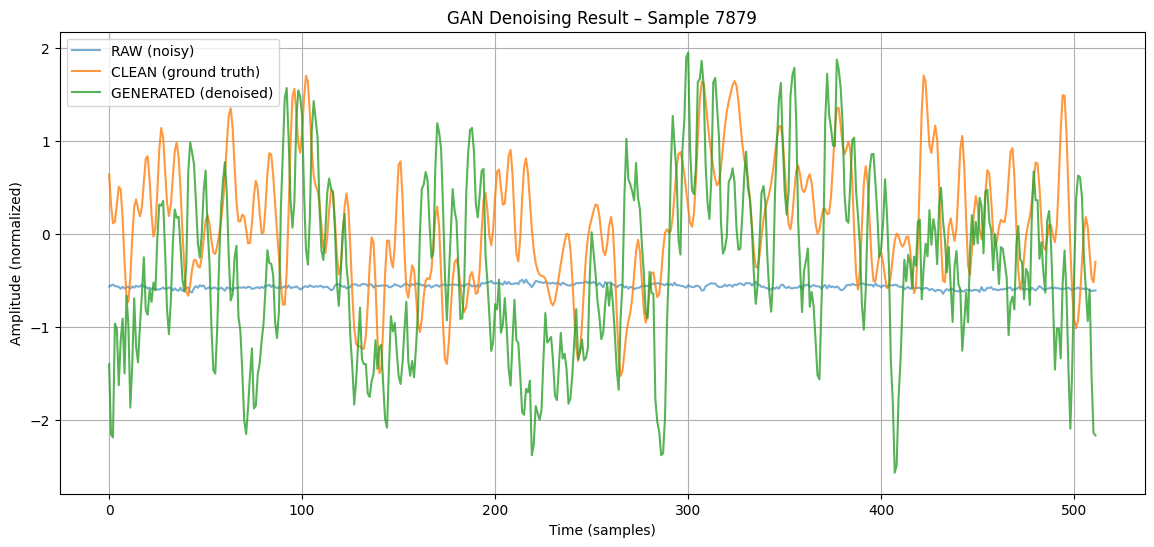

In [97]:
metrics = evaluate_gan_sample(G, final_X_raw, final_X_clean, device)